In [36]:
# import kmapper as km
import numpy as np
import pandas as pd
import gudhi
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from Persistent_Homology_Ivanov import PHI

In [4]:
import numpy as np
import pandas as pd
import gudhi
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer


class PHI:
    def __init__(self, bare_text):
        self.bare_text = bare_text

    def text_bow(self, splitter='\n'):
        cv = CountVectorizer()
        corpus = self.bare_text.split(splitter)
        count_v = cv.fit(corpus) # cv.fit() creates the dictionary of all the unique words in the corpus.
        self.bow = cv.transform(corpus).toarray()
        
    def point_cloud(self):
        self.bow = self.bare_text
        
    def dist_calc(self, custom_dist):
        distance_matrix = pairwise_distances(self.bow, metric='euclidean')
        if custom_dist:
            distance_max = custom_dist
        else:
            distance_max = max(map(max, distance_matrix))
        return (distance_matrix, distance_max)
    
    def sif(self, max_dim=3, custom_dist=False):
        distance_matrix, distance_max = self.dist_calc(custom_dist)
        rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=distance_max)
        self.simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
        
    def sifts(self, max_dim=3, custom_dist=False):
        distance_matrix, distance_max = self.dist_calc(custom_dist)
        for i in range(len(self.bow)-1):
            distance_matrix[i+1][i] = 0
        rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=distance_max)
        self.simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    
    def alpha(self):
        rips_complex = gudhi.AlphaComplex(points=self.bow)
        self.simplex_tree = rips_complex.create_simplex_tree()
        
    def ph_barcode(self, dimentions=[0,1]):
        # work in progress on for dimention in dimentions:
        self.simplex_tree.compute_persistence(min_persistence=0.3)
        diag0 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[0])
        diag1 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[1]) 
        fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5, 4), dpi=100)
        gudhi.plot_persistence_barcode(diag0, axes=ax0)
        gudhi.plot_persistence_barcode(diag1, axes=ax1)
        
        ax0.set_title('dimention 0')
        ax1.set_title('dimention 1')
        fig.tight_layout()
        plt.show()
        
    def full_sif_sifts(self, dimentions=[0,1], custom_dist=False):
        self.sif(max_dim=3, custom_dist=False)        
        self.simplex_tree.compute_persistence(min_persistence=0.3)
        
        sif_diag0 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[0])
        sif_diag1 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[1])
        
        self.sifts(max_dim=3, custom_dist=False)
        self.simplex_tree.compute_persistence(min_persistence=0.3)
        
        sifts_diag0 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[0])
        sifts_diag1 = self.simplex_tree.persistence_intervals_in_dimension(dimentions[1])

        fig, ((sif_ax0, sifts_ax0), (sif_ax1, sifts_ax1)) = plt.subplots(nrows=2, ncols=2, figsize=(5, 4), dpi=100)

        gudhi.plot_persistence_barcode(sif_diag0, axes=sif_ax0)
        gudhi.plot_persistence_barcode(sif_diag1, axes=sif_ax1)
        gudhi.plot_persistence_barcode(sifts_diag0, axes=sifts_ax0)
        gudhi.plot_persistence_barcode(sifts_diag1, axes=sifts_ax1)
        
        sif_ax0.set_title('SIF (dimention 0)')
        sif_ax1.set_title('SIF (dimention 1)')
        sifts_ax0.set_title('SIFTS (dimention 0)')
        sifts_ax1.set_title('SIFTS (dimention 1)')
        
        #sif_ax0.invert_yaxis()
        #sif_ax1.invert_yaxis()
        #sifts_ax0.invert_yaxis()
        #sifts_ax1.invert_yaxis()
        
        fig.tight_layout()
        plt.show()

In [6]:
data = [[1, 1], [7, 0], [4, 6], [9, 6], [0, 14], [2, 19], [9, 17]]

In [7]:
compl = PHI(data)
compl.point_cloud()

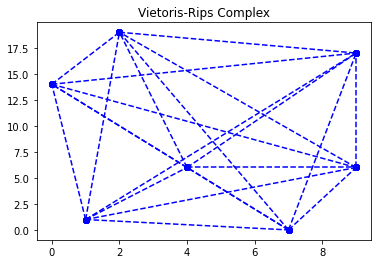

In [74]:
compl.sif(max_dim=2)
for sk_value in compl.simplex_tree.get_skeleton(1):
    if sk_value[1]:
        point1, point2 = data[sk_value[0][0]], data[sk_value[0][1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, 'bo', linestyle="--")
        plt.title("Vietoris-Rips Complex")

In [73]:
sns.scatterplot(data)

NameError: name 'sns' is not defined

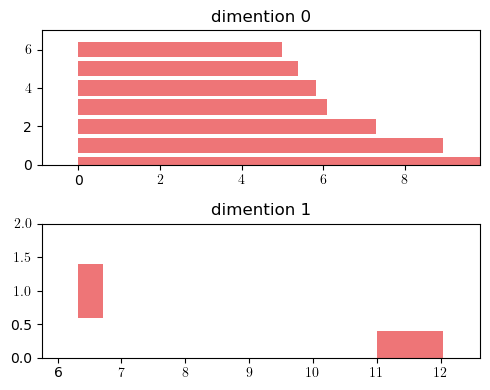

In [8]:
compl.ph_barcode()

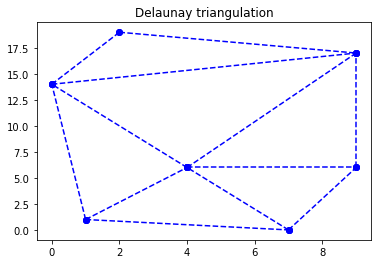

In [51]:
compl.alpha()
for sk_value in compl.simplex_tree.get_skeleton(1):
    if sk_value[1]:
        point1, point2 = data[sk_value[0][0]], data[sk_value[0][1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, 'bo', linestyle="--")
        plt.title("Delaunay triangulation")
        


In [66]:
shape = 10,10
dot_x = [2,5,7,2]                               
dot_y = [2,5,2,7]
points = ([2,2], [5,5],
          [7,2], [2,7])  
def Z(X,Y):                     #матрица значений Z параболоида
    return (X-x)**2 + (Y-y)**2
for i,(x,y) in enumerate(points):    #кол-во циклов определяется числом точек
    paraboloid = np.fromfunction(Z,(shape))  #создается массив Z для отдельной точки
    colors = np.where(paraboloid < field,i+1,colors) #заполняется цветовая матрица
    field = np.where(paraboloid < field,paraboloid,field)

    fig = plt.figure(figsize=plt.figaspect(0.5))   
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X = np.arange(0, 10, 1)
    Y = np.arange(0, 10, 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, paraboloid,rstride=1, cstride=1, cmap=cm.magma,
                       linewidth=0, antialiased=False)
    ax.set_zlim(0, 100)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    ax = fig.add_subplot(1, 2, 2)
    C = numpy.transpose(colors)
    ax.imshow(C, cmap=cm.magma, alpha = 1)
    ax.scatter(dot_x, dot_y , c = 'Red')
    ax.scatter(dot_x[i], dot_y[i] , c = 'Blue')
    plt.show()

NameError: name 'field' is not defined

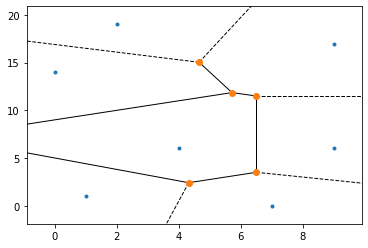

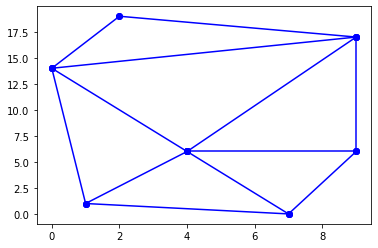

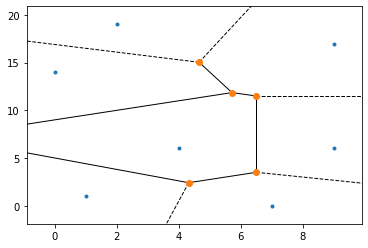

In [34]:
compl.alpha()
for sk_value in compl.simplex_tree.get_skeleton(1):
    if sk_value[1]:
        point1, point2 = data[sk_value[0][0]], data[sk_value[0][1]]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, 'bo', linestyle="-")
        
vor = Voronoi(data)
voronoi_plot_2d(vor)

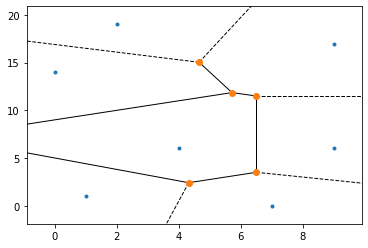

In [28]:
vor = Voronoi(data)
fig = voronoi_plot_2d(vor)
plt.show()

In [24]:

vor.ridge_vertices

[[-1, 3],
 [-1, 4],
 [3, 4],
 [-1, 2],
 [2, 3],
 [-1, 0],
 [0, 4],
 [0, 1],
 [1, 2],
 [-1, 5],
 [-1, 5],
 [1, 5]]

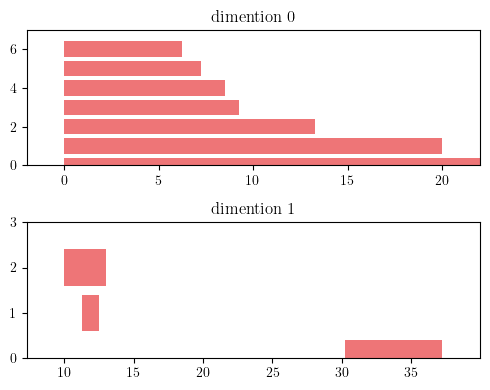

In [26]:
compl.ph_barcode()

In [ ]:
dpznm rjkkjrdbevs ary pfgbcb
записи открытые выступления заседания ученого совета
на сайте вышки
выступление лимонченко рук топологии
преза желательно
ссылки на его работы и на работы китайцев которые сделали angular momentum
след неделя как добится оконтуривания дырок
языки
фильтрации
witness filtration 



In [1]:
BERT
пост-BERTIAN сети
СВД

SyntaxError: invalid syntax (<ipython-input-1-203f552790b3>, line 2)

In [64]:
energy = int(input())
counter = 1
while energy<=1000:
    energy+=150
    counter += 1
print(counter)

1500
1
